# House Price Prediction from Begginer's

In [11]:
# base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Важная настройка для корректной настройки pipeline!
import sklearn
sklearn.set_config(transform_output="pandas")

# Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler, OrdinalEncoder, TargetEncoder
from sklearn.model_selection import GridSearchCV, KFold

# for model learning
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score

#models
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier
from catboost import CatBoostRegressor
from sklearn.compose import ColumnTransformer, make_column_selector
# Metrics
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor


# tunning hyperparamters model
import optuna

In [12]:
#  указываем, что бы отображались все столбцы и при необходимости 100 строк.
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', 100)    

In [13]:
# Загружаем датасеты
test = pd.read_csv("data/test.csv")
train = pd.read_csv("data/train.csv")
submission = pd.read_csv("data/sample_submission.csv")

In [14]:
# Предварительный просмотр
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [15]:
# Смотрим данные по таргету
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [16]:
# Проверяем наличие пропуско и тип 
pd.DataFrame(data={'NaN_count': train.isna().sum(), 'data_type':train.dtypes}).T   

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
NaN_count,0,0,0,259,0,0,1369,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,872,8,0,0,0,37,37,38,37,0,38,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,690,81,81,81,0,0,81,81,0,0,0,0,0,0,0,1453,1179,1406,0,0,0,0,0,0
data_type,int64,int64,str,float64,int64,str,str,str,str,str,str,str,str,str,str,str,str,int64,int64,int64,int64,str,str,str,str,str,float64,str,str,str,str,str,str,str,int64,str,int64,int64,int64,str,str,str,str,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,str,int64,str,int64,str,str,float64,str,int64,int64,str,str,str,int64,int64,int64,int64,int64,int64,str,str,str,int64,int64,int64,str,str,int64


In [17]:
# смотрим количество пропущенных значений 
temp_df = pd.DataFrame({
    'Missing_Values': train.isna().sum(),
    'Missing_Values_Percent': (train.isna().mean() * 100)
}).sort_values('Missing_Values_Percent', ascending=False)

print(temp_df)

               Missing_Values  Missing_Values_Percent
PoolQC                   1453               99.520548
MiscFeature              1406               96.301370
Alley                    1369               93.767123
Fence                    1179               80.753425
MasVnrType                872               59.726027
FireplaceQu               690               47.260274
LotFrontage               259               17.739726
GarageQual                 81                5.547945
GarageFinish               81                5.547945
GarageType                 81                5.547945
GarageYrBlt                81                5.547945
GarageCond                 81                5.547945
BsmtFinType2               38                2.602740
BsmtExposure               38                2.602740
BsmtCond                   37                2.534247
BsmtQual                   37                2.534247
BsmtFinType1               37                2.534247
MasVnrArea                  

Text(0.5, 1.0, 'SalePrice distribution')

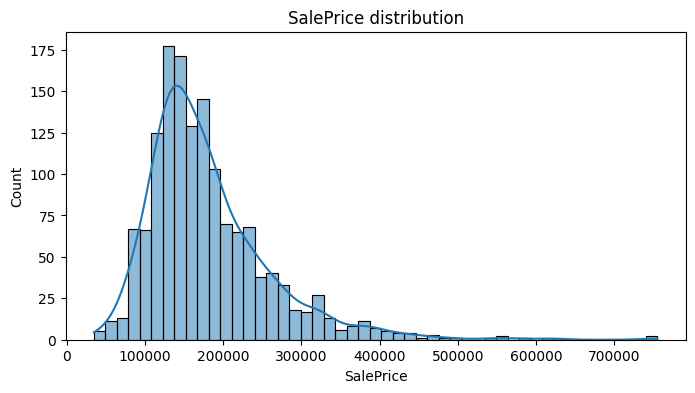

In [18]:
# График по таргету
plt.figure(figsize=(8,4))
sns.histplot(train["SalePrice"], kde=True)
plt.title("SalePrice distribution")

Наблюдаем правоскошенное распределение и несколько дорогих квартир, которые вытягивают график. Так же видим выбросы. В целом наблюдаем типичную картину для цен в недвижимости.
Поскольку из-за шума и выбросов в регрессии модель может быть переобучена, необходимо применить функцию потерь(loss), чтобы ослабить влияние выбросов.

Text(0.5, 1.0, 'SalePrice — log1p')

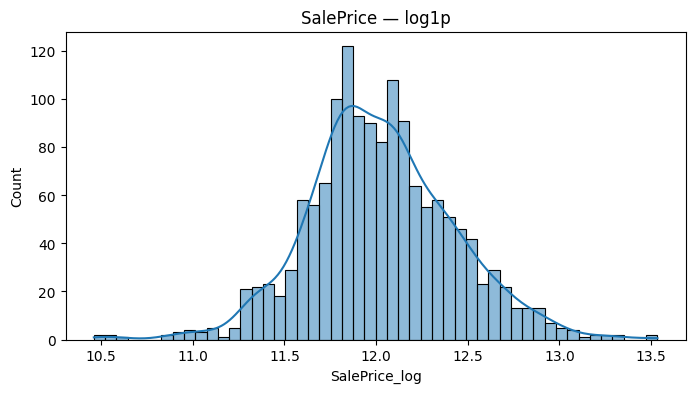

In [19]:
train["SalePrice_log"] = np.log1p(train["SalePrice"])
plt.figure(figsize=(8,4))
sns.histplot(train["SalePrice_log"], bins=50, kde=True)
plt.title("SalePrice — log1p")

In [20]:
# Делим на категориальные и числовые признаки
num_features = train.select_dtypes(include=['number']).columns.tolist()  
cat_features = train.select_dtypes(include='object')

/tmp/ipykernel_35834/2390489786.py:3: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  cat_features = train.select_dtypes(include='object')


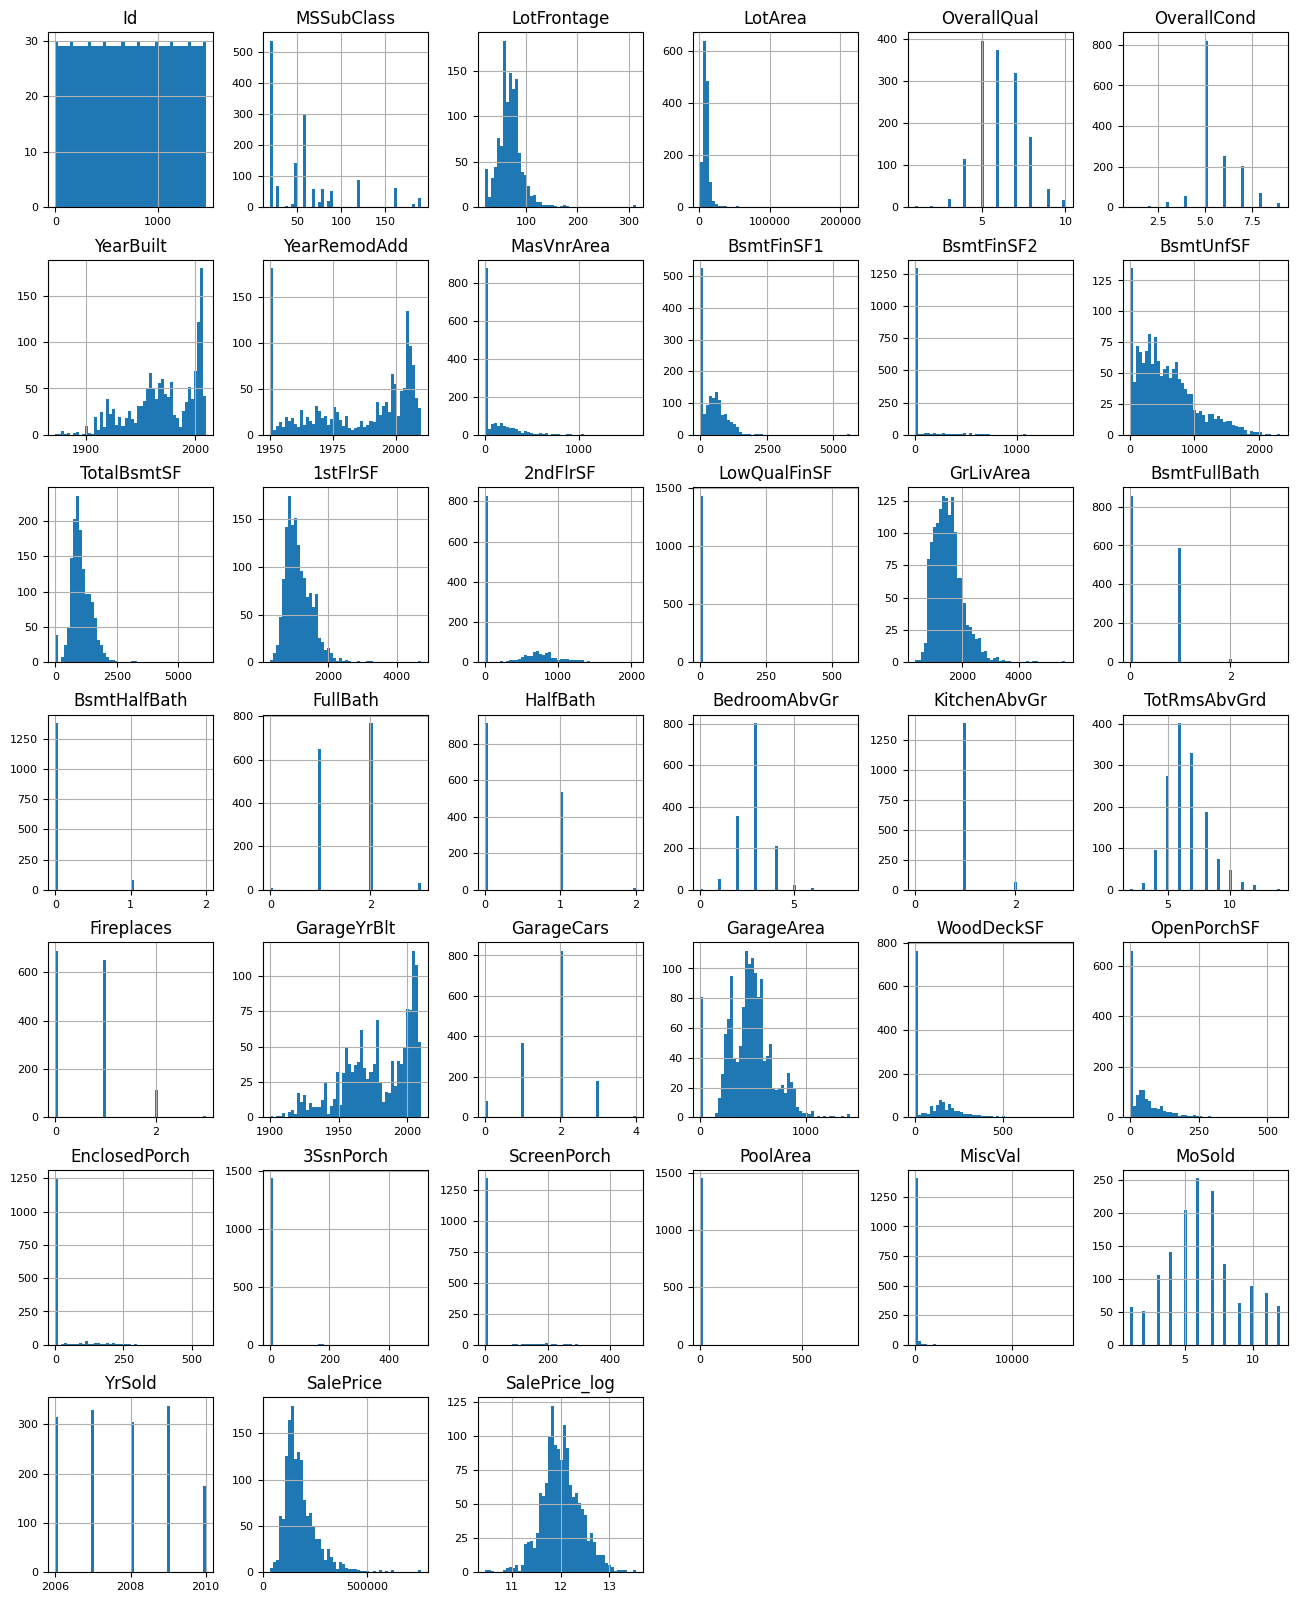

In [21]:
# Строим графики по числовым данным
train[num_features].hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

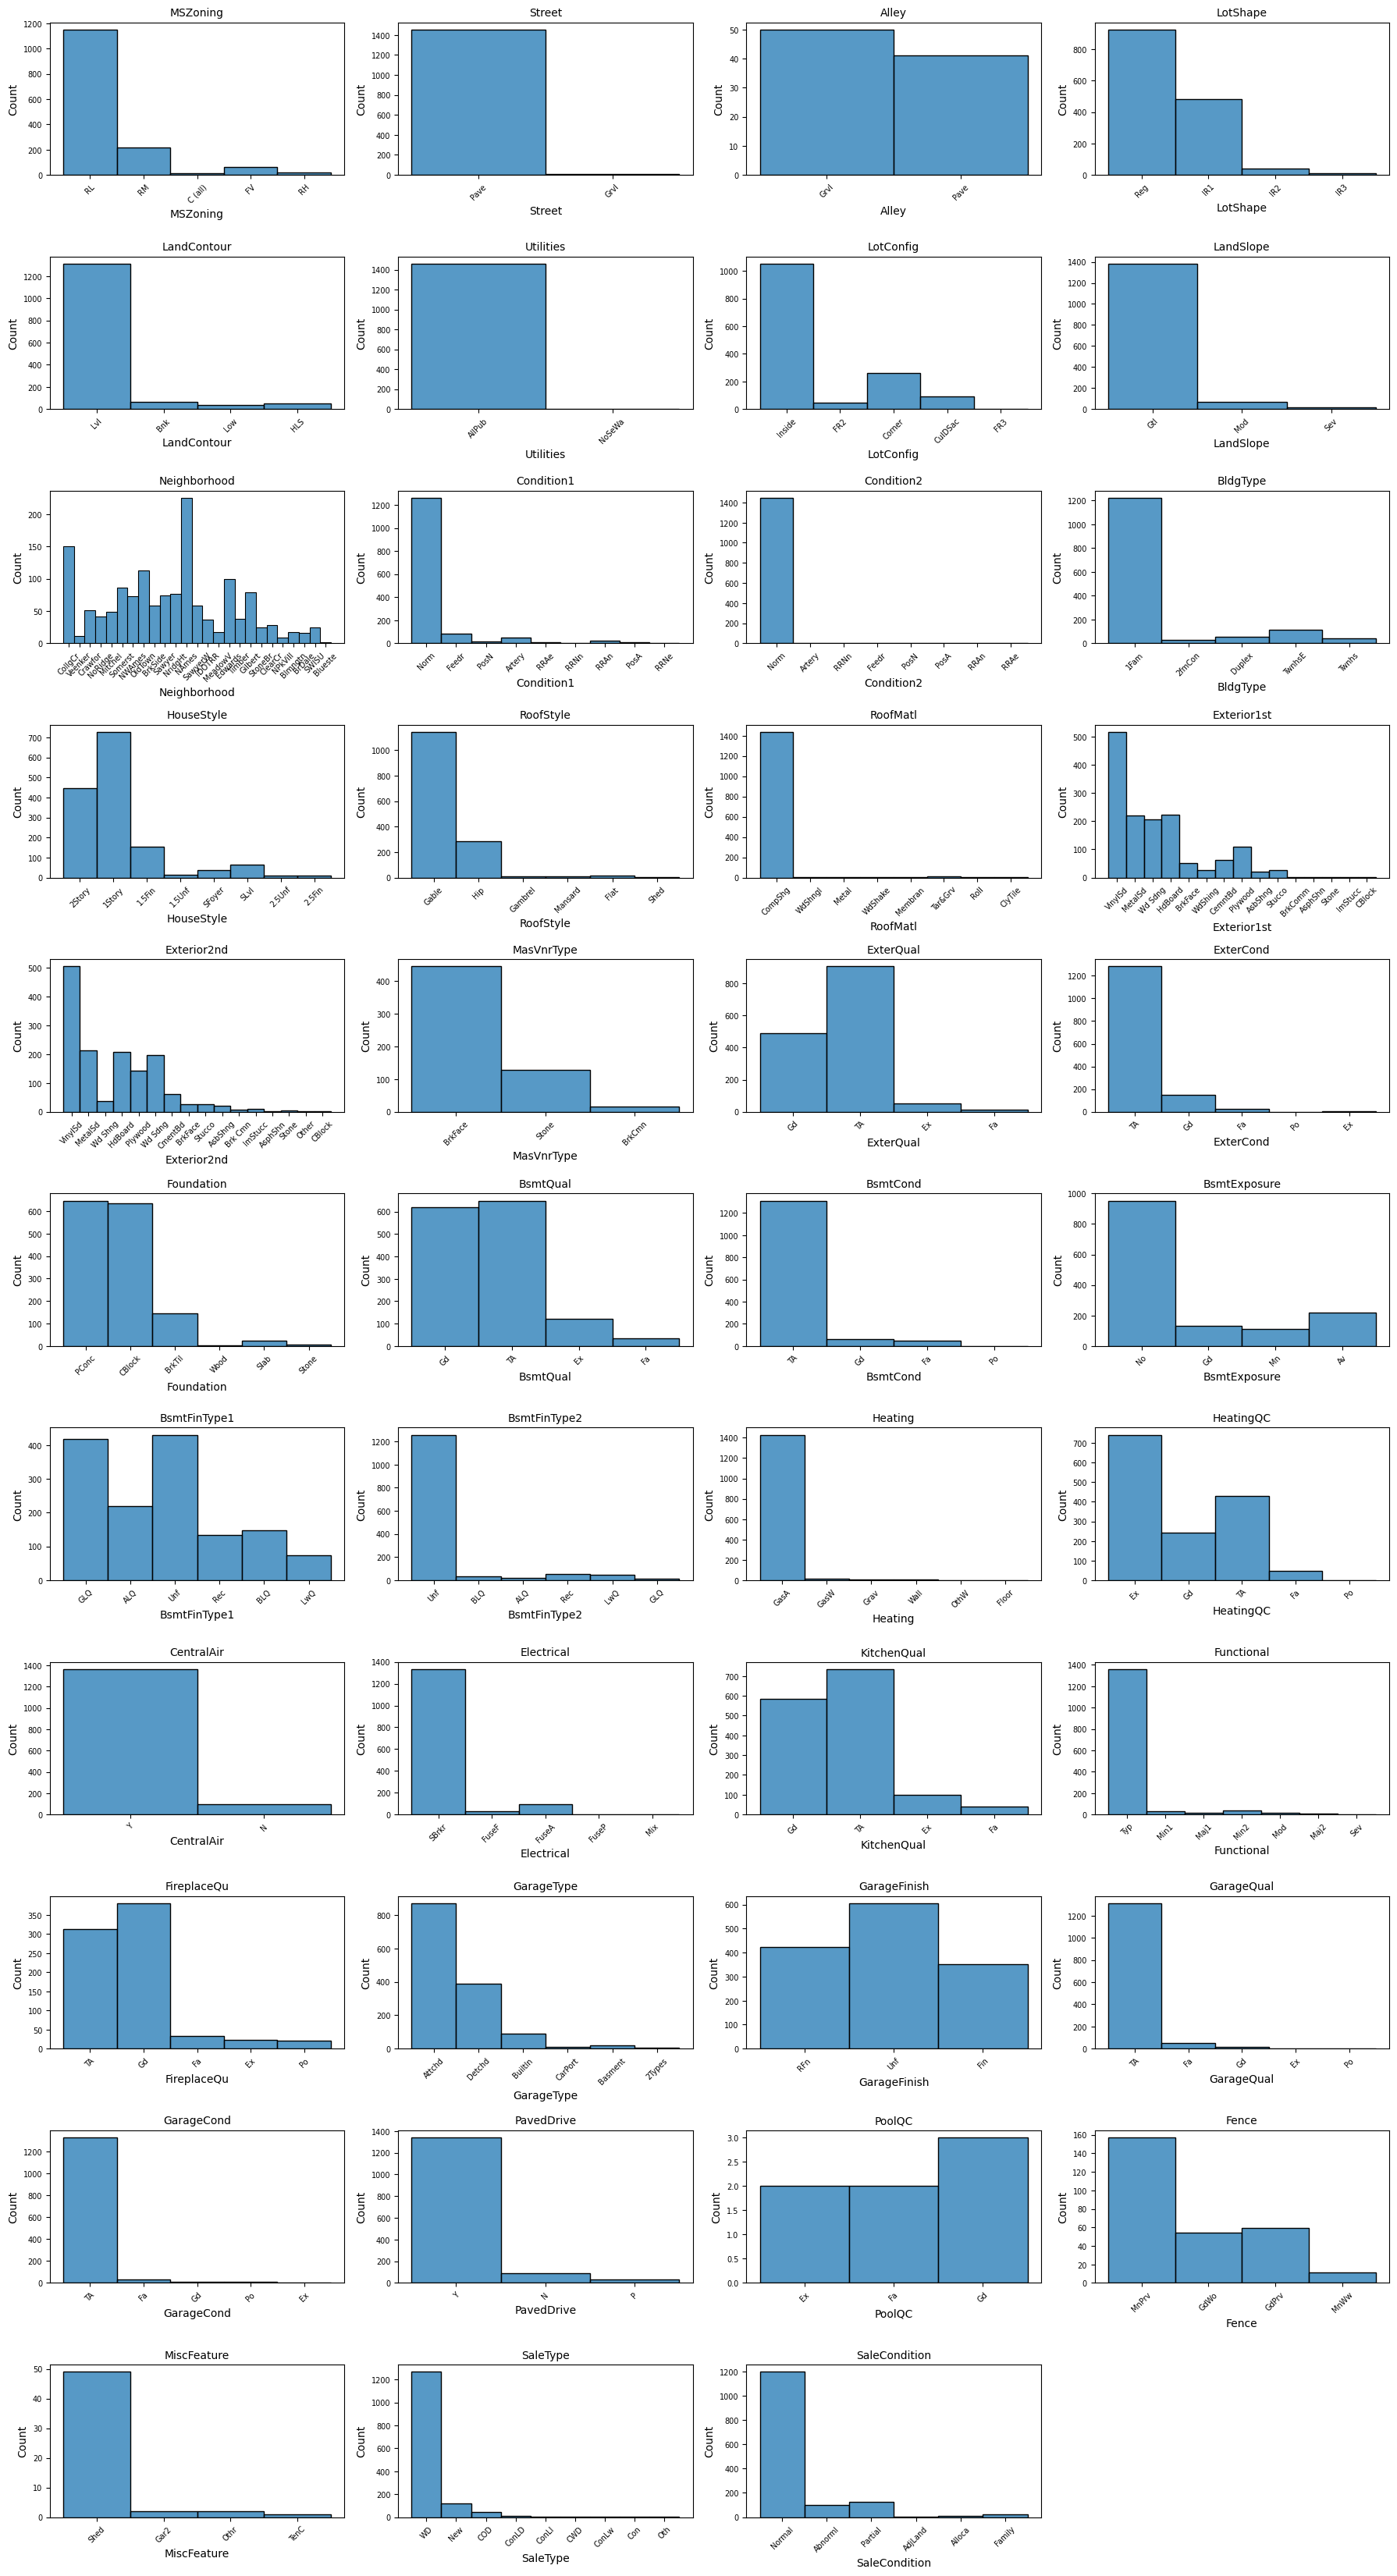

In [22]:
# Строим графики по категориальным данным
n_cols = 4
n_features = len(cat_features)
n_rows = (n_features + n_cols - 1) // n_cols  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 3))
axes = axes.flatten()

for i, col in enumerate(cat_features):
    sns.histplot(x=train[col], ax=axes[i])
    axes[i].set_title(col, fontsize=10)
    axes[i].tick_params(axis='x', labelsize=7, rotation=45)
    axes[i].tick_params(axis='y', labelsize=7)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### Предварительный анализ категориальных признаков

MSZoning. Доминирует жилая застройка низкой плотности, дальше идет жилая застройка средней плотности, остальные редкие. Тип зонирования представлен неравномерно, но признак может быть полезный

Street. Преимущественно везде асфальт, гравия почти нет. Поскольку преобладвет один тип, вероятнее всего эта категория не несёт информации. 

Alley. На графике две категории гравий и асфальт. Однако так же содержится много пропусков, однако эти Nan зозначают отсутствие доступа к переулку. Необходимо заполнить отдельной категорией “NoAlley”.

LotShape. Сильно доминирует нормальная форма участка, далее идет слегка заметная, остальные редкие. Значит форма участка влияет, но редкие категории могут дать шум. 

LandContour. Почти весь рельеф участка ровный, остальные сильно меньше. Значит “рельеф участка” обычно одинаковый, но редкие значения могут быть информативны. 

Utilities. На графике мы видим, что почти все публичные комуникации доступны. Значит почти константа, возможно надо будет удалить.

LotConfig. Идим разные конфигурации участка, преимущественно внутренний и угловой, где внутренний доминирует, остальные встречаются реже. Значит “конфигурация участка” может влиять на стоимость.

LandSlope. Уклон участка преимущественно один: легкий. Значит почти константа, возможно надо будет удалить.

Neighborhood. Много категорий, распределение неоднородное. Возможно это один из самых сильных факторов. 

Condition1/Condition2. Близость к объектам почти везде нормальная, остальные редкие (Feedr, Artery и т.п.). Значит “соседство с дорогой/жд” может оказывать влияние.

BldgType. Отдельные дома доминирует, остальные представленны меньше. Значит тип здания влияет.

HouseStyle. Одноэтажные и двухэтажные дома доминируют, остальные встречаются реже. Значит стиль/этажность важны. 

RoofStyle. Амбарный стиль крыши доминирует, вальмовые крыши так же имеют заметный вес, прочие редкие.

RoofMatl. Практически константа, видим только композиционную черепицу. Возможно необходимо удалить.

Exterior1st/Exterior2nd. Несколько крупных категорий и хвост редких. Значит материал фасада важен.

MasVnrType. Доминирует облицовочный кирпич, остальные редкие. Однако у нас 60% пропущенных значений. Значение пропусков вероятнее "нет отделки" необходимо заполнить отдельной категорией.

ExterQual/ExterCond. В категориях качества видно, что 'среднее' и 'хорошее' преобладают. Это порядковая шкала, которую необходимо закодировать.

Foundation. Нормальное распределение нескольких категорий, оставляем и кодируем.

BsmtQual. На графике видно распределение по высоте подвала, NA(2,5%) означает “нет подвала”. 

BsmtCond. Состояние подвала, почти всё "типичное"; плюс NA(2,5%) обработаем как отсутствие подвала.

BsmtExposure. Окна у подвалов отсутствуют. Пропуски обработаем по аналогии выше.

BsmtFinType1. Тип отделки подвала преимущественно 'хороший' и 'незаконченный'. Пропуски обработаем по аналогии выше.

BsmtFinType2. Второй тип отделки — почти всегда 'незаконченный', остальные редкие. Почти константа, возможно стоит объединить или удалить.

Heating. Почти всё газ. Опять-таки константа, вороятнее нужно будет удалить.

HeatingQC. 5 разных качеств отопления оаспределены по всему графику. 

CentralAir. Практически везде наличие центрального кондиционера. Необходим дальнейший анализ оставлять ли данную категорию.

Electrical. В электросистемах преобладают 'автоматы'. Возможно стоит оставить ли категории, а остальные объединить.

KitchenQual. На графике видно 4 разных вида качества кухни, возможно есть взаимосвязь со стоимостью.

Functional. Преобладает типичная функциональность, остальные редкие. Можно объединить всё в “Other”.

FireplaceQu. в категории 'качество камина' у нас 47% NA, которые интерпретируются как 'нет камина'. Видно две крупные категории и хвост. 

GarageType. Из нескольких видов гаражей преобладают 'соединен с домом' и 'отдельно от дома'. Значения NA означают отсутствие гаража.

GarageFinish. Отделка гаража состоит из 'закончена', 'незакончена', 'черновая отделка'. Значения NA означают отсутствие гаража.

GarageQual/GarageCond. Качество/состояние гаража 'типичное'. Почти что константа.Значения NA означают отсутствие гаража.

PavedDrive. Часиная парковка почти всё 'да'. Посмотреть корреляцию и в зависимости от результата, возможно удалить.

PoolQC. В графике видно несколько столбиков, однако там почти все NA, что означет 'отсутствие бассейна'.

Fence. Мало показательных наблюдений, NA означает “нет забора”. Д.

MiscFeature. В прочих объектах большую долю составляют NA/None, немного Shed. Необходимо переквалифицировать NA в 'отсутствие'.

SaleType. Доминирует'договор купли продажи', так же заметны новые дома, остальные редкие. Возможно редкие стоит объединить в “Other”.

SaleCondition. В условиях сделки преобладают: 'типичные'. 

<Axes: >

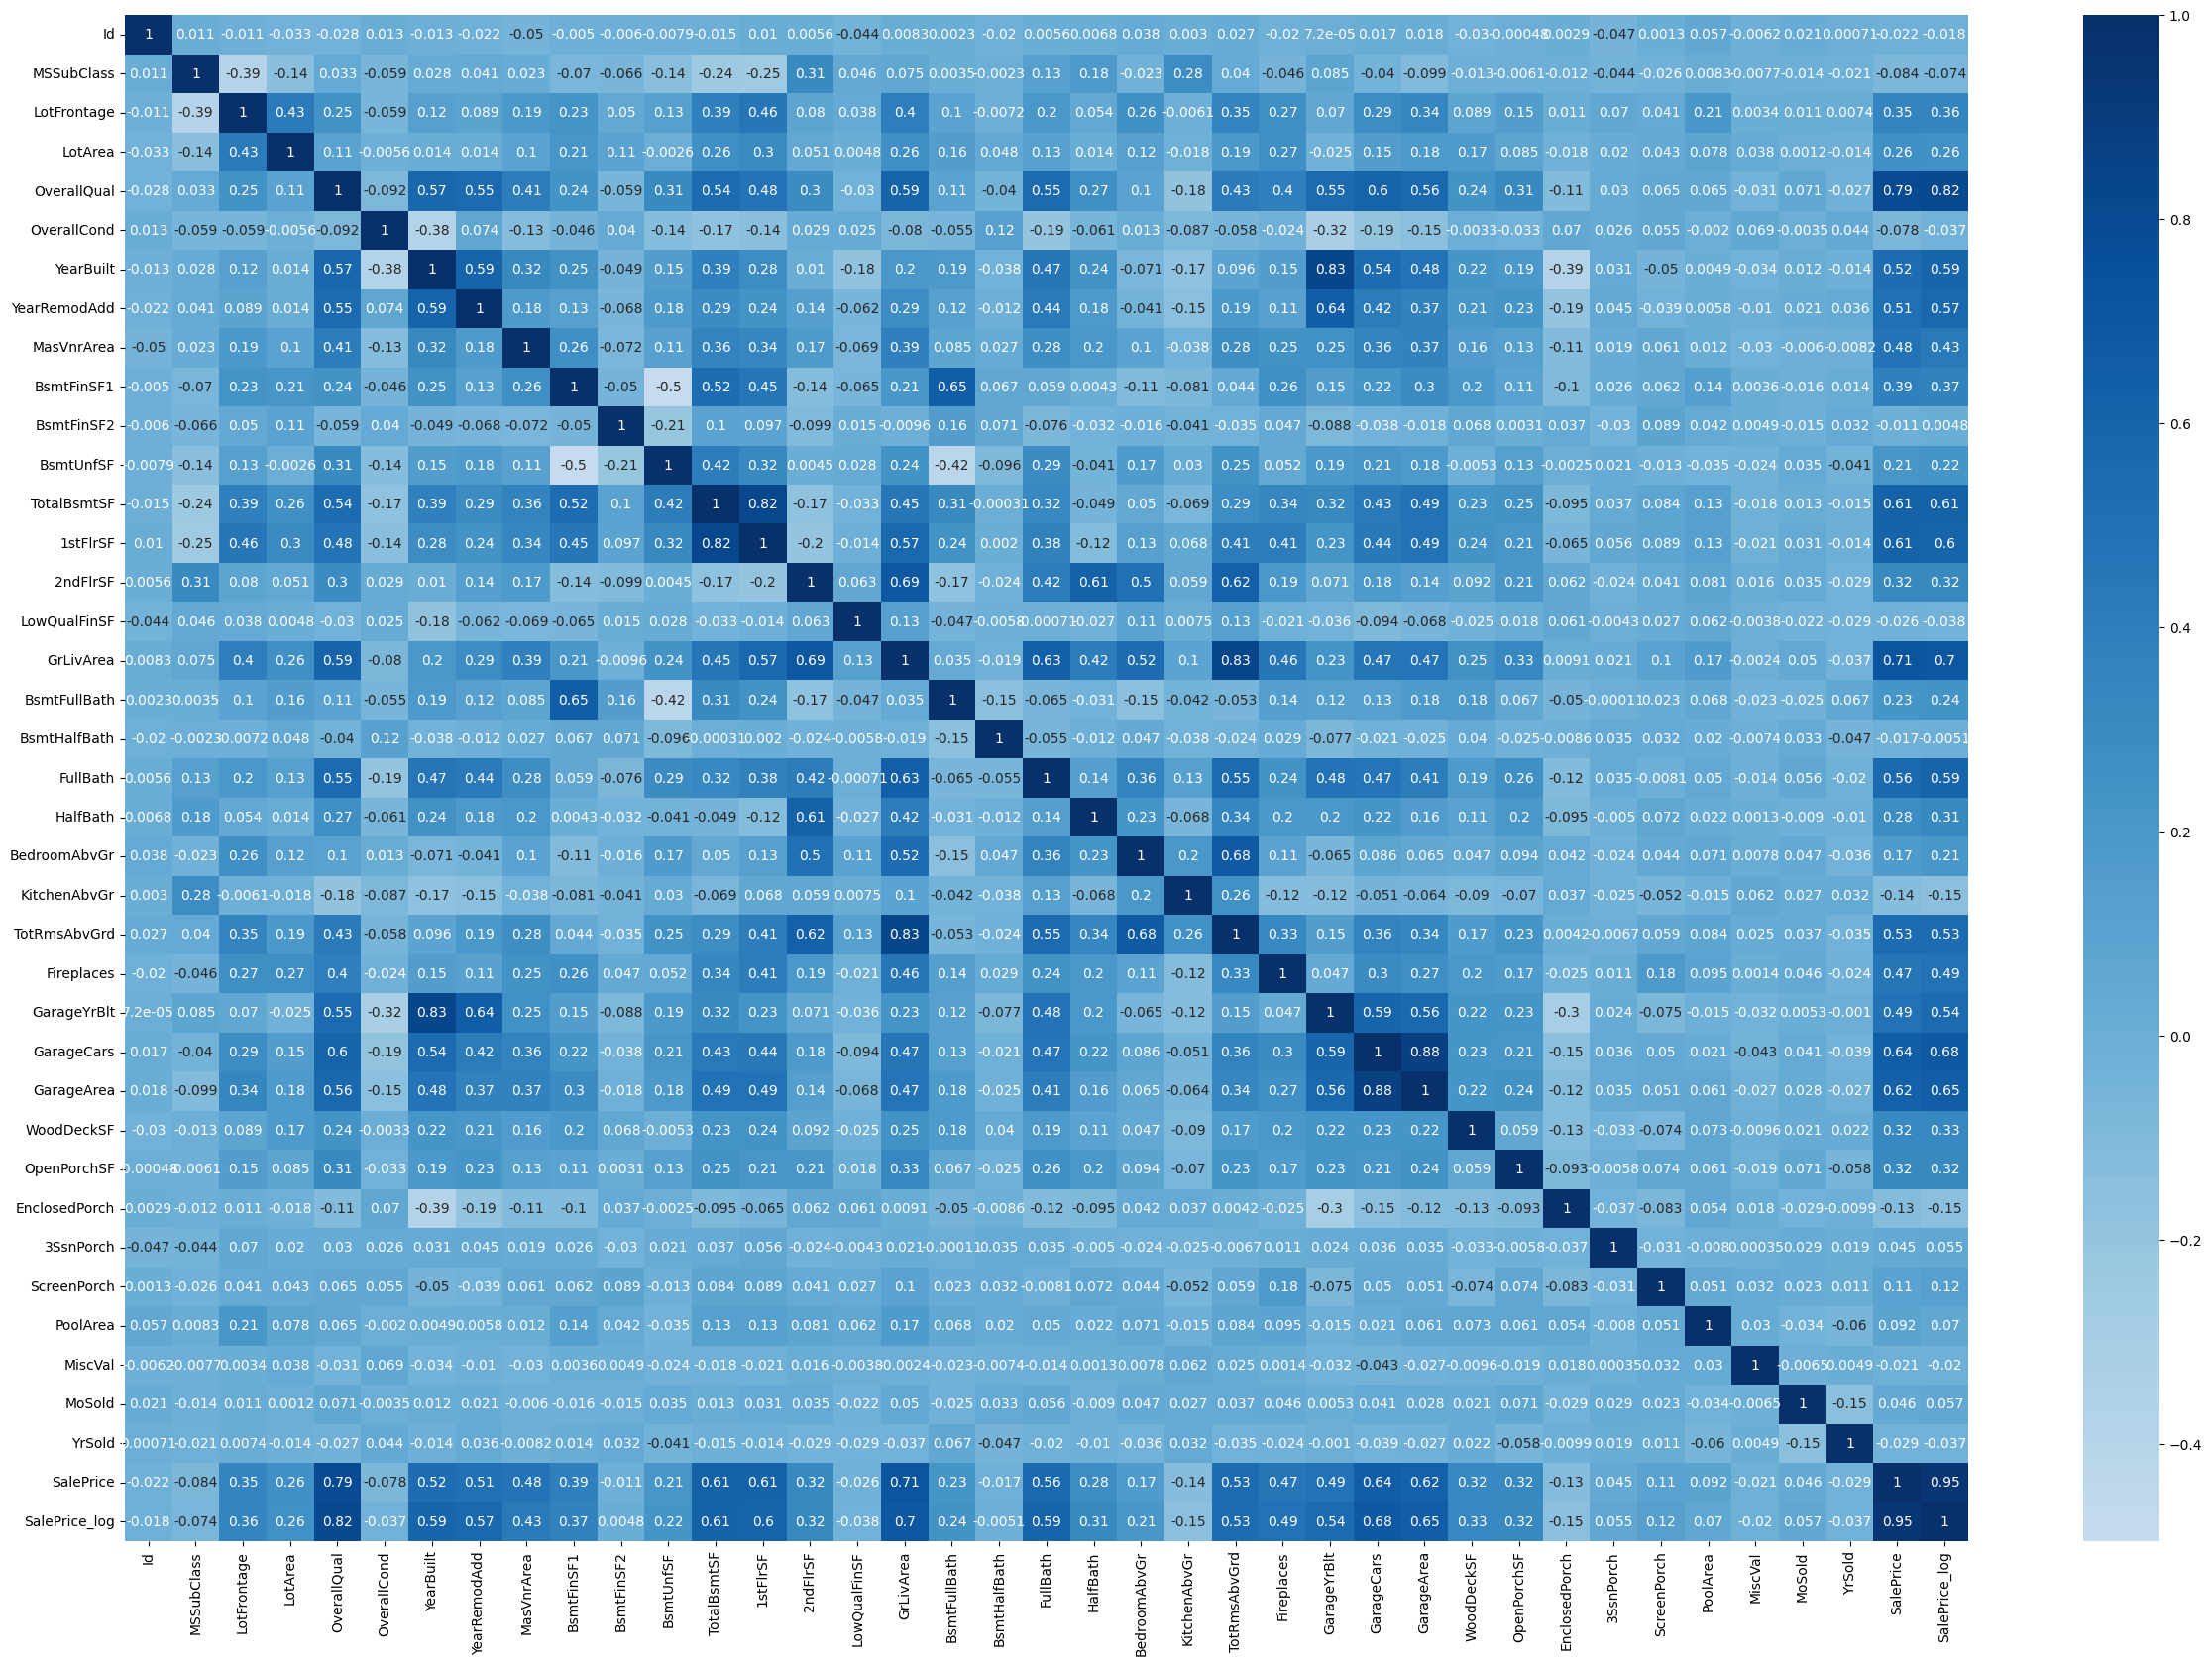

In [23]:
# Смотрим с какими признаками коррелирует целевая переменная SalePrice
corr = train[num_features].corr() 
plt.figure(figsize=(30,20)) 
sns.heatmap(corr, center=0, cmap="Blues", annot=True)  

In [24]:
corr = train[num_features].corr()
corr_with_target = corr["SalePrice_log"].sort_values(key=lambda x: abs(x), ascending=False)
corr_with_target

SalePrice_log    1.000000
SalePrice        0.948374
OverallQual      0.817185
GrLivArea        0.700927
GarageCars       0.680625
GarageArea       0.650888
TotalBsmtSF      0.612134
1stFlrSF         0.596981
FullBath         0.594771
YearBuilt        0.586570
YearRemodAdd     0.565608
GarageYrBlt      0.541073
TotRmsAbvGrd     0.534422
Fireplaces       0.489450
MasVnrArea       0.430809
BsmtFinSF1       0.372023
LotFrontage      0.355879
WoodDeckSF       0.334135
OpenPorchSF      0.321053
2ndFlrSF         0.319300
HalfBath         0.313982
LotArea          0.257320
BsmtFullBath     0.236224
BsmtUnfSF        0.221985
BedroomAbvGr     0.209043
EnclosedPorch   -0.149050
KitchenAbvGr    -0.147548
ScreenPorch      0.121208
MSSubClass      -0.073959
PoolArea         0.069798
MoSold           0.057330
3SsnPorch        0.054900
LowQualFinSF    -0.037963
YrSold          -0.037263
OverallCond     -0.036868
MiscVal         -0.020021
Id              -0.017942
BsmtHalfBath    -0.005149
BsmtFinSF2  

Наибольшую корреляцию мы наблюдаем со следующими признаками:
                                                            OverallQual (0,82)
                                                            GrLivArea (0,70)
                                                            YearBuilt / YearRemodAdd (0,58)
                                                            TotalBsmtSF (0,60)
                                                            1stFlrSF (0,60)
                                                            FullBath (0.60)
                                                            GarageCars / GarageArea (0,66)
Признаки с низкой корреляцией (менее 0.05):
                                            Id(-0,018)
                                            OverallCond(-0.037)
                                            BsmtFinSF2(0.0048)
                                            LowQualFinSF(-0.038)
                                            3SsnPorch(0.055)
                                            MiscVal(-0.02)

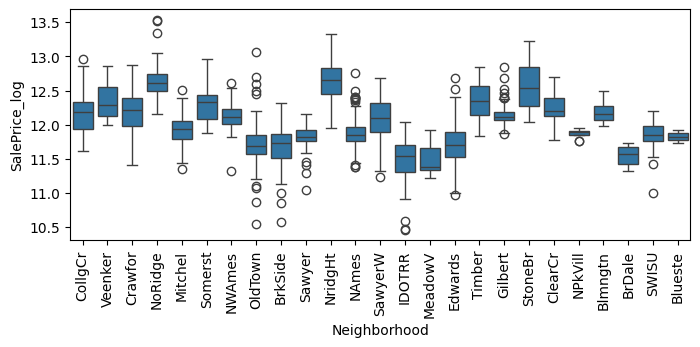

In [25]:
plt.figure(figsize=(8,3))
sns.boxplot(x=train["Neighborhood"], y=train["SalePrice_log"])
plt.xticks(rotation=90)
plt.show()

Разные районы дают разный уровень цен. Есть «дорогие» районы (StoneBr, NridgHt), есть «дешёвые» (IDOTRR, BrDale). Район — самый сильный категориальный фактор.

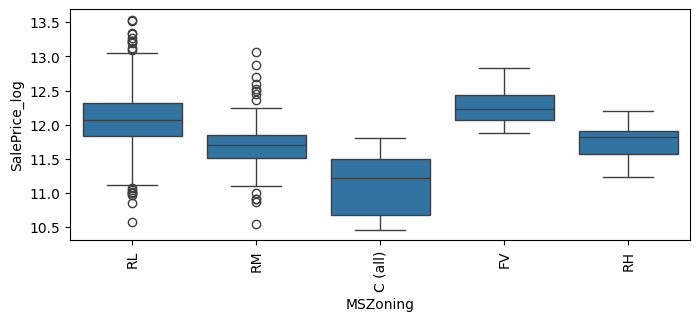

In [26]:
plt.figure(figsize=(8,3))
sns.boxplot(x=train["MSZoning"], y=train["SalePrice_log"])
plt.xticks(rotation=90)
plt.show()

MSZoning: жилые зоны низкой плотности (RL) дороже остальных.

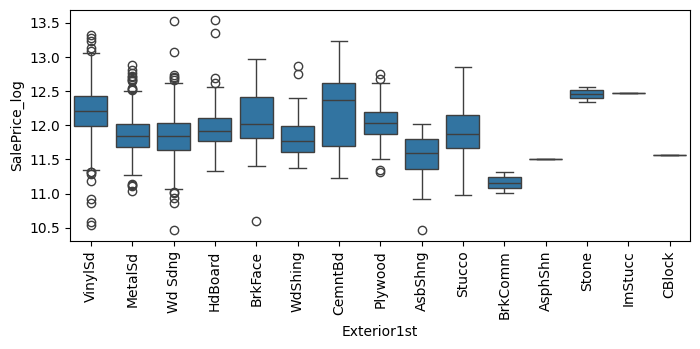

In [27]:
plt.figure(figsize=(8,3))
sns.boxplot(x=train["Exterior1st"], y=train["SalePrice_log"])
plt.xticks(rotation=90)
plt.show()

Exterior1st: качественная отделка (Stone, Brick, Cement) → более высокая цена; дешёвая отделка → более низкая.

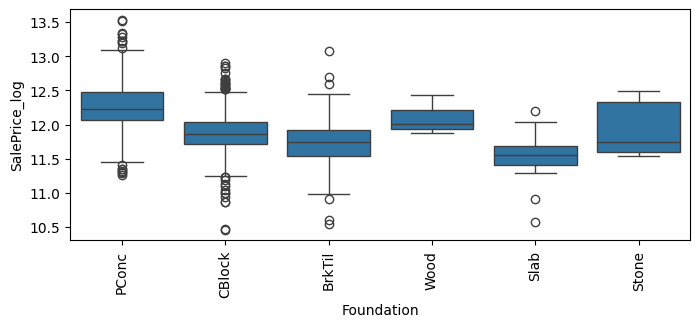

In [28]:
plt.figure(figsize=(8,3))
sns.boxplot(x=train["Foundation"], y=train["SalePrice_log"])
plt.xticks(rotation=90)
plt.show()

Foundation: бетонный фундамент (PConc) дороже всех; Slab и CBlock — самые дешёвые.

In [29]:
# объединяем два датасета удаляя колонку с таргет
train["SalePrice_log"] = np.log1p(train["SalePrice"])

X = train.drop('SalePrice', axis=1)
y = train['SalePrice']

df = pd.concat([X, test], axis=0, ignore_index=True)

In [30]:
#  меняем тип колонок
df["MSSubClass"] = df["MSSubClass"].astype(str)
df["OverallQual"] = df["OverallQual"].astype(str)
df["OverallCond"] = df["OverallCond"].astype(str)

In [31]:
#  Создаем колонки, необходимые для заполнения пропусков

columns_none = ["Alley", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "FireplaceQu", "GarageType", 
             "GarageFinish", "GarageQual", "GarageCond", "PoolQC", "Fence", "MiscFeature", "MasVnrType"]

columns_cat_fill = ["MSZoning", "Exterior1st", "Exterior2nd", "KitchenQual", "SaleType", "Electrical", "Functional", "Utilities"]

all_cat_cols = df.select_dtypes(include='object').columns.tolist()
other_cat_cols = [c for c in all_cat_cols if c not in set(columns_none + columns_cat_fill)]


/tmp/ipykernel_35834/3486234472.py:8: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  all_cat_cols = df.select_dtypes(include='object').columns.tolist()


In [32]:
# Собираем препроцессоры для разных типов колонок в один объект. 

preprocessor = ColumnTransformer(                                                                   
    transformers = [
        ('none_imputer', SimpleImputer(strategy='constant', fill_value="None"), columns_none),            
        ('unknown_imputer', SimpleImputer(strategy='most_frequent'), columns_cat_fill),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), other_cat_cols)       
    ],
    verbose_feature_names_out = False,                  
    remainder = 'passthrough'                            
)

In [33]:
X_df = df.drop(columns=['SalePrice', 'SalePrice_log'], errors='ignore')
y = train['SalePrice_log']

X_train, X_valid, y_train, y_valid = train_test_split(
    X_df.iloc[:len(train)], y, test_size=0.2, random_state=42
)

In [34]:
pipe = Pipeline(steps=[
    ('prep', preprocessor),
    ('model', RandomForestRegressor(
        n_estimators=300, random_state=42, n_jobs=-1
    ))
])

In [36]:
pipe.fit(X_train, y_train)
pred_valid = pipe.predict(X_valid)

ValueError: could not convert string to float: 'None'

In [ ]:
pred_test = pipe.predict(df.iloc[len(train):])

submission['SalePrice'] = np.expm1(pred_test)
submission.to_csv("my_submission.csv", index=False)